In [5]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.metrics import r2_score
from utils import target_cols, feat_cols

In [10]:
# using giba's dataset since it's already in parquet format
# Dataset: https://www.kaggle.com/datasets/titericz/leap-dataset-giba
# This dataset was created using all train and test data.
# Train is 10M samples and was split in 17 parquet files. Test is a single parquet file.
# /kaggle/input/leap-dataset-giba/
train_files = sorted(glob("./data/train_batch/*.parquet"))
test_files = glob("./data/test_batch/*.parquet")

In [11]:
# Train on 2/8 of the full dataset
train = pd.read_parquet(train_files[:1]).astype('float32')
# Validate on last parquet file (625000 samples)
valid = pd.read_parquet(train_files[-1]).astype('float32')
test  = pd.read_parquet(test_files[0]).astype('float32')

train.shape, valid.shape, test.shape

((625000, 793), (625000, 793), (625000, 491))

In [17]:
test.head()

,sample_id,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,...,pbuf_N2O_17,pbuf_N2O_18,pbuf_N2O_19,pbuf_N2O_20,pbuf_N2O_21,pbuf_N2O_22,pbuf_N2O_23,pbuf_N2O_24,pbuf_N2O_25,pbuf_N2O_26
0,169651.0,209.750,220.750,227.750,241.375,254.625,262.25,261.25,254.000,243.875,...,4.172325e-07,4.172325e-07,4.172325e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07
1,524862.0,208.375,219.250,228.250,242.125,256.250,263.75,261.75,253.625,243.750,...,3.576279e-07,4.172325e-07,4.172325e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07
2,634129.0,213.125,229.375,233.375,242.625,252.875,261.00,261.00,253.000,240.875,...,4.172325e-07,4.172325e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07
3,403572.0,212.000,226.000,231.000,241.000,252.875,262.25,262.00,253.125,241.125,...,4.172325e-07,4.172325e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07
4,484578.0,207.875,216.750,227.875,243.500,257.500,265.25,263.00,253.750,243.500,...,3.576279e-07,4.172325e-07,4.172325e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07,4.768372e-07


# Model

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score

In [54]:
class TabularModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.dp1 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dp1(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

## Data processing

In [75]:
filtered_feat_cols = [col for col in feat_cols if col in train.columns]
filtered_target_cols = [col for col in target_cols if col in train.columns]

for i, n in enumerate([filtered_feat_cols, filtered_target_cols]):
    f = [feat_cols, target_cols][i]
    missing_cols = [col for col in f if col not in filtered_target_cols]
    print(f"Warning: Columns {missing_cols} not found in the data")
    print(f"Using only {len(n)} columns out of {len(f)}")

Using only 490 columns out of 556
Using only 302 columns out of 368


In [92]:
# giba's dataset has dropped some columns, so we need to filter them out
def get_input_data(data, is_feat=True):
    f = filtered_feat_cols if is_feat else filtered_target_cols
    return data[f].values


X_train = get_input_data(train, True)
y_train = get_input_data(train, False)
X_valid = get_input_data(valid, True)
y_valid = get_input_data(valid, False)

In [93]:
input_size = X_train.shape[1]  # len(feat_cols)  # number of input features
output_size = y_train.shape[1]  # len(target_cols)  # number of output features

# Initialize model
model = TabularModel(input_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training loop

In [94]:
num_epochs = 10

# tensors for convenience
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_valid_tensor = torch.tensor(X_valid)
y_valid_tensor = torch.tensor(y_valid)

# history
train_losses = []
valid_losses = []
train_r2_scores = []
valid_r2_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients

    # Forward pass
    outputs = model(X_train_tensor)

    # Compute loss
    loss = criterion(outputs, y_train_tensor)

    # Backward pass
    loss.backward()

    for name, param in model.named_parameters():
        if 'fc5' not in name:
            param.grad = None

    optimizer.step()

    # Compute R2 score
    train_preds = model(X_train_tensor).detach().numpy()
    valid_preds = model(X_valid_tensor).detach().numpy()

    train_r2 = r2_score(y_train, train_preds)
    valid_r2 = r2_score(y_valid, valid_preds)

    train_losses.append(loss.item())
    valid_losses.append(valid_r2)
    train_r2_scores.append(train_r2)
    valid_r2_scores.append(valid_r2)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train R2: {train_r2:.4f}, Valid R2: {valid_r2:.4f}")


 10%|█         | 1/10 [00:46<06:56, 46.24s/it]

Epoch [1/10], Loss: 20.8973, Train R2: -2116696537679672576.0000, Valid R2: -1845042251760868553392128.0000


 20%|██        | 2/10 [01:21<05:19, 39.94s/it]

Epoch [2/10], Loss: 3.4016, Train R2: -908239583504530560.0000, Valid R2: -795322693952129355218944.0000


 30%|███       | 3/10 [01:59<04:31, 38.74s/it]

Epoch [3/10], Loss: 2.1229, Train R2: -450711656409330752.0000, Valid R2: -398287535967276887965696.0000


 40%|████      | 4/10 [02:37<03:51, 38.58s/it]

Epoch [4/10], Loss: 1.6508, Train R2: -303938431201440896.0000, Valid R2: -263453835316489835511808.0000


 50%|█████     | 5/10 [03:20<03:21, 40.32s/it]

Epoch [5/10], Loss: 1.4172, Train R2: -197399618178752448.0000, Valid R2: -175857471672784240246784.0000


 60%|██████    | 6/10 [03:53<02:31, 37.85s/it]

Epoch [6/10], Loss: 1.2882, Train R2: -122194440558303840.0000, Valid R2: -106582673090409960308736.0000


 70%|███████   | 7/10 [04:32<01:54, 38.19s/it]

Epoch [7/10], Loss: 1.2028, Train R2: -89714059691638432.0000, Valid R2: -79073288966098464538624.0000


 80%|████████  | 8/10 [05:05<01:13, 36.55s/it]

Epoch [8/10], Loss: 1.1556, Train R2: -54204299037236224.0000, Valid R2: -47075526127696197189632.0000


 90%|█████████ | 9/10 [05:38<00:35, 35.28s/it]

Epoch [9/10], Loss: 1.1232, Train R2: -26910146925312176.0000, Valid R2: -23532317618205601300480.0000


100%|██████████| 10/10 [06:11<00:00, 37.19s/it]

Epoch [10/10], Loss: 1.1008, Train R2: -15252295179154518.0000, Valid R2: -13656765719031591206912.0000


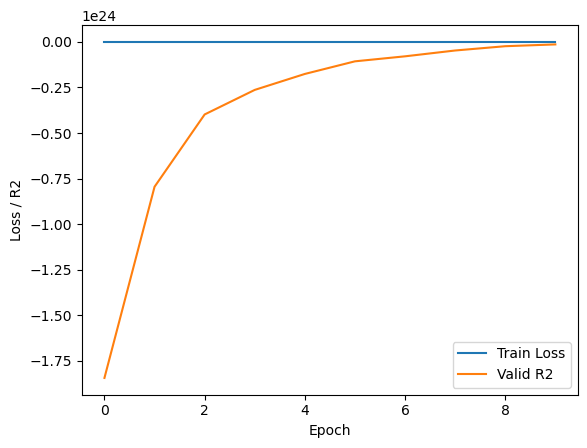

In [95]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid R2')
plt.xlabel('Epoch')
plt.ylabel('Loss / R2')
plt.legend()
plt.show()

# Predict

In [79]:
X_test = torch.tensor(get_input_data(test, True))
test_preds = model(X_test).detach().numpy()
test_preds = pd.DataFrame(test_preds, columns=filtered_target_cols)

# Write submission file

In [62]:
# /kaggle/input/leap-atmospheric-physics-ai-climsim
weights = pd.read_csv("./data/sample_submission.csv", nrows=1)
weights = weights.drop(['sample_id'], axis=1).T.to_dict()[0]

In [89]:
set(filtered_target_cols) - set(test_preds.columns)

set()

In [90]:
submission = pd.read_csv("./data/sample_submission.csv")

for col in tqdm(filtered_target_cols):
    if weights[col] > 0:
        submission[col] = test_preds[col].values
    else:
        submission[col] = 0.
        
submission.to_csv('submission.csv', index=False)        
submission.head()

100%|██████████| 302/302 [00:05<00:00, 54.49it/s]


,sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
0,test_169651,-0.545411,0.656683,0.819095,1.322784,-0.510279,2.020569,-0.288234,1.420132,-2.635216,...,3.590868,-1.014814,-0.319090,4.114001,-1.387763,-0.797865,-1.210394,-1.609248,-0.033920,2.197917
1,test_524862,-0.609285,2.108539,0.563204,1.192242,-0.553749,0.623614,-1.520159,0.820504,-3.073966,...,2.149581,2.065135,-0.206421,2.331555,-2.456176,0.675187,-0.273587,-1.956471,-1.625339,2.244554
2,test_634129,-1.213737,-0.114074,1.432602,0.015002,-0.166612,2.268651,-0.503124,3.613167,-4.739151,...,3.533390,2.110069,-0.673640,2.688759,-2.469991,-0.049785,-0.316239,-0.911005,-3.096332,1.462231
3,test_403572,-0.008903,-0.313070,0.917899,3.203015,1.355351,0.258972,-0.507111,0.792349,-5.267419,...,2.115077,1.309831,-0.987785,2.151760,-1.539400,-1.501522,0.057080,-0.864071,0.142043,-0.081925
4,test_484578,-1.587302,2.319473,0.190565,-0.100965,0.629180,-0.967829,-0.126905,1.534175,-2.267677,...,1.745634,2.064975,-0.777585,3.215446,-1.214559,0.714900,-0.188883,-1.980971,0.692985,2.850944
